In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./titanic_data/titanic.csv')

In [4]:
# 1. Exploratory Data Analysis (EDA)
print("\nDataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())


Dataset Shape: (891, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [5]:
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Text(0.5, 1.0, 'Survival Count')

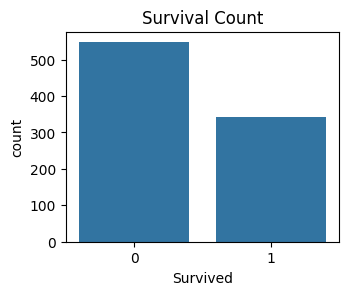

In [7]:
plt.figure(figsize=(12, 6))
# Survival count
plt.subplot(2, 3, 1)
sns.countplot(x='Survived', data=df)
plt.title('Survival Count')

Text(0.5, 1.0, 'Survival by Gender')

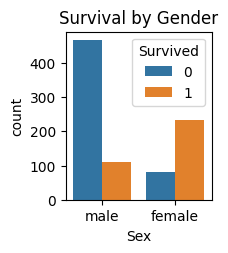

In [8]:
# Survival by gender
plt.subplot(2, 3, 2)
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Survival by Gender')

Text(0.5, 1.0, 'Survival by Passenger Class')

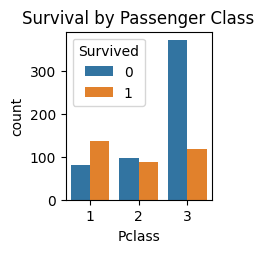

In [9]:
# Survival by passenger class
plt.subplot(2, 3, 3)
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival by Passenger Class')

Text(0.5, 1.0, 'Age Distribution')

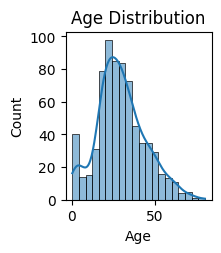

In [10]:
# Age distribution
plt.subplot(2, 3, 4)
sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Age Distribution')

Text(0.5, 1.0, 'Fare Distribution')

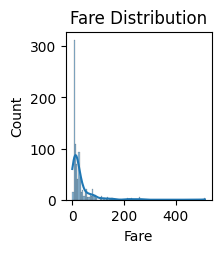

In [11]:
# Fare distribution
plt.subplot(2, 3, 5)
sns.histplot(df['Fare'], kde=True)
plt.title('Fare Distribution')

Text(0.5, 1.0, 'Survival by Embarkation Point')

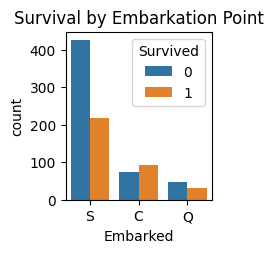

In [12]:
# Survival by embarkation point
plt.subplot(2, 3, 6)
sns.countplot(x='Embarked', hue='Survived', data=df)
plt.title('Survival by Embarkation Point')

Text(0.5, 1.0, 'Correlation Heatmap')

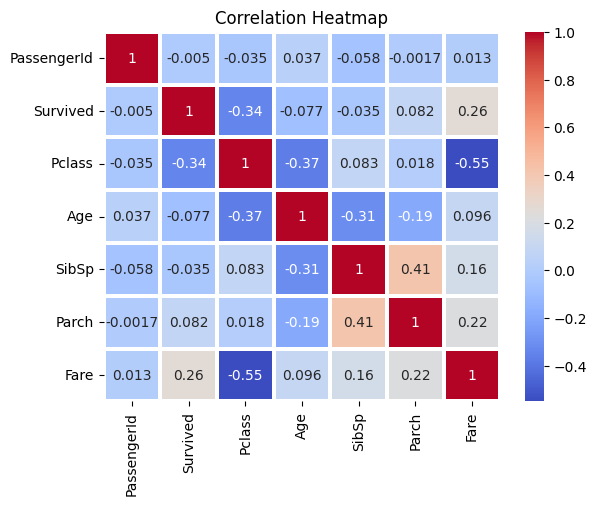

In [13]:
# Correlation heatmap for numerical features
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=1.5)
plt.title('Correlation Heatmap')

In [14]:
# 2. Data Preprocessing and Feature Engineering
# Create a copy of the DataFrame for preprocessing
df_processed = df.copy()

In [15]:
# Extract titles from names
df_processed['Title'] = df_processed['Name'].str.extract(
    ' ([A-Za-z]+)\.', expand=False)
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Col': 'Rare',
    'Major': 'Rare',
    'Mlle': 'Miss',
    'Countess': 'Rare',
    'Ms': 'Miss',
    'Lady': 'Rare',
    'Jonkheer': 'Rare',
    'Don': 'Rare',
    'Dona': 'Rare',
    'Mme': 'Mrs',
    'Capt': 'Rare',
    'Sir': 'Rare'
}

In [16]:
df_processed['Title'] = df_processed['Title'].map(lambda x: title_mapping.get(x, 'Rare'))

In [17]:
# Create family size feature
df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1

In [18]:
# Create IsAlone feature
df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)

In [19]:
# Create Fare bins
df_processed['FareBin'] = pd.qcut(df_processed['Fare'], 4, labels=False)

In [20]:
# Create Age bins
df_processed['AgeBin'] = pd.cut(df_processed['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])

In [21]:
# Fill missing values in Age with median by passenger class and gender
age_median = df_processed.groupby(['Pclass', 'Sex'])['Age'].median()
for pclass in df_processed['Pclass'].unique():
    for sex in df_processed['Sex'].unique():
        df_processed.loc[(df_processed['Age'].isnull()) & 
                         (df_processed['Pclass'] == pclass) & 
                         (df_processed['Sex'] == sex), 'Age'] = age_median[pclass, sex]

In [22]:
# Fill missing values in Embarked with most frequent value
df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0], inplace=True)

In [23]:
# Drop unnecessary columns
df_processed.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

In [24]:
# Print the processed data info
print("\nProcessed Data Info:")
print(df_processed.info())
print("\nProcessed Data Sample:")
print(df_processed.head())


Processed Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Sex         891 non-null    object  
 3   Age         891 non-null    float64 
 4   SibSp       891 non-null    int64   
 5   Parch       891 non-null    int64   
 6   Fare        891 non-null    float64 
 7   Embarked    891 non-null    object  
 8   Title       891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  FareBin     891 non-null    int64   
 12  AgeBin      714 non-null    category
dtypes: category(1), float64(2), int64(7), object(3)
memory usage: 84.7+ KB
None

Processed Data Sample:
   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked Title  \
0         0       3    male  22.0      1      0   7.2500       

In [25]:
# 3. Feature Selection and Model Building
# Define features and target
X = df_processed.drop('Survived', axis=1)
y = df_processed['Survived']

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Define preprocessing steps
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'FareBin']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone', 'AgeBin']

In [28]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [29]:
# Define models to test
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}



Model Performance:

LogisticRegression:
  Cross-validation Accuracy: 0.8266 ± 0.0398
  Test Accuracy: 0.8209
  Precision: 0.8058
  Recall: 0.7477
  F1 Score: 0.7757

RandomForest:
  Cross-validation Accuracy: 0.7978 ± 0.0256
  Test Accuracy: 0.7836
  Precision: 0.7431
  Recall: 0.7297
  F1 Score: 0.7364

GradientBoosting:
  Cross-validation Accuracy: 0.8154 ± 0.0442
  Test Accuracy: 0.8134
  Precision: 0.8427
  Recall: 0.6757
  F1 Score: 0.7500

SVC:
  Cross-validation Accuracy: 0.8282 ± 0.0388
  Test Accuracy: 0.8246
  Precision: 0.8333
  Recall: 0.7207
  F1 Score: 0.7729

XGBoost:
  Cross-validation Accuracy: 0.8074 ± 0.0252
  Test Accuracy: 0.7948
  Precision: 0.7692
  Recall: 0.7207
  F1 Score: 0.7442


<Figure size 1400x800 with 0 Axes>

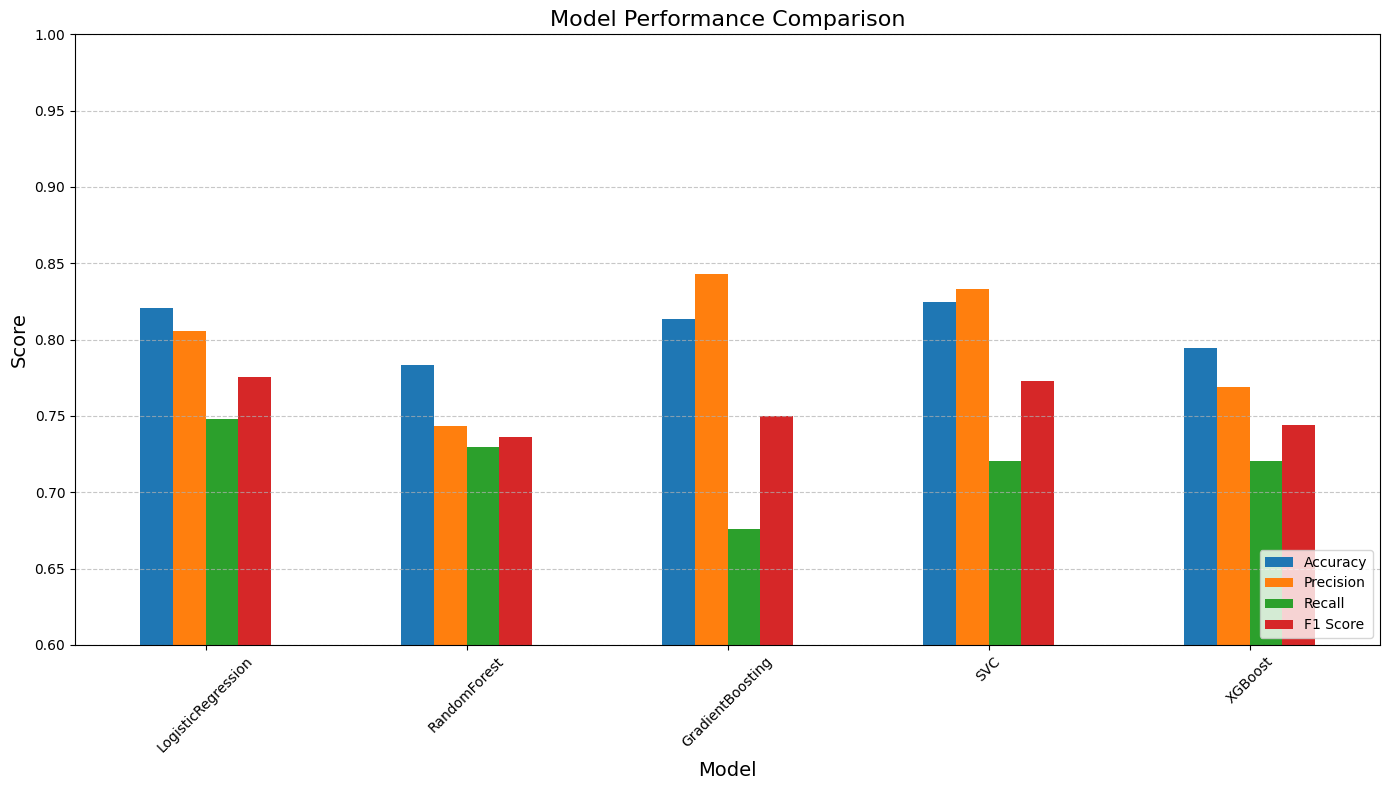

In [30]:
# Train and evaluate models
print("\nModel Performance:")

# Dictionary to store results
results = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

model_names = []

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # Cross-validation
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    
    # Train on full training set
    pipe.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = pipe.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store results
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)
    model_names.append(name)

    print(f"\n{name}:")
    print(f"  Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

# Now you can create the DataFrame outside the loop
results_df = pd.DataFrame(results, index=model_names)

# Plot
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylim(0.6, 1.0)  # Adjust as needed
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./images/model_comparison.png')
plt.show()

In [57]:
# 4. Hyperparameter Tuning for the Best Model

# Define the pipeline
xg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(random_state=42))])

In [58]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__min_child_weight': [1, 3, 5]
}

In [59]:
# Create grid search
grid_search = GridSearchCV(xg_pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)


Best Parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 300, 'classifier__subsample': 0.9}
Best Cross-validation Score: 0.8427870967741935


In [60]:
# Predict with best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate best model
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print("\nBest Model Performance:")
print(f"  Test Accuracy: {accuracy_best:.4f}")
print(f"  Precision: {precision_best:.4f}")
print(f"  Recall: {recall_best:.4f}")
print(f"  F1 Score: {f1_best:.4f}")


Best Model Performance:
  Test Accuracy: 0.8134
  Precision: 0.7905
  Recall: 0.7477
  F1 Score: 0.7685


In [ ]:
# 5. Feature Importance
print("\n===== Feature Importance =====")

# Get feature importance from the best model if it's a tree-based model
if hasattr(best_model[-1], 'feature_importances_'):
    # Get feature names
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if isinstance(transformer, Pipeline) and hasattr(transformer.steps[-1][1], 'get_feature_names_out'):
            transformed_features = transformer.steps[-1][1].get_feature_names_out(features)
            feature_names.extend(transformed_features)
        else:
            feature_names.extend(features)
    
    # Get feature importances
    importances = best_model[-1].feature_importances_
    
    # Create a DataFrame for visualization
    feature_imp = pd.DataFrame({
        'Feature': feature_names[:len(importances)],
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nTop 10 Important Features:")
    print(feature_imp.head(10))
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10))
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.savefig('./images/feature_importance.png')
    plt.close()


===== Feature Importance =====

Top 10 Important Features:
         Feature  Importance
16      Title_Mr    0.372938
9     Sex_female    0.122411
8       Pclass_3    0.117387
14  Title_Master    0.076991
4     FamilySize    0.039424
6       Pclass_1    0.030963
11    Embarked_C    0.028273
13    Embarked_S    0.025705
17     Title_Mrs    0.025639
15    Title_Miss    0.020209


Text(0.5, 14.722222222222216, 'Predicted Label')

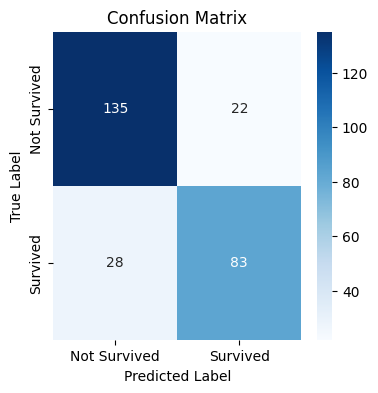

In [62]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Survived', 'Survived'], 
            yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [63]:
# 7. Classification Report
print("\n===== Classification Report =====")
report = classification_report(y_test, y_pred_best)
print(report)


===== Classification Report =====
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       157
           1       0.79      0.75      0.77       111

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.81      0.81      0.81       268



In [ ]:
# Save the best model
joblib.dump(best_model, './models/titanic_survival_model.pkl')
print("\nBest model saved as 'titanic_survival_model.pkl'")


Best model saved as 'titanic_survival_model.pkl'


In [ ]:
# Save the preprocessor
joblib.dump(preprocessor, './models/preprocessor.pkl')
print("\nPreprocessor saved as 'preprocessor.pkl'")


Preprocessor saved as 'preprocessor.pkl'


In [68]:
def predict_new_passenger(passenger_data, model_path='titanic_survival_model.pkl', preprocessor_path='preprocessor.pkl'):
    # Load the model and preprocessor
    try:
        model = joblib.load(model_path)
        preprocessor = joblib.load(preprocessor_path)
    except Exception as e:
        print(f"Error loading model or preprocessor: {e}")
        return None, None

    # Convert single passenger data to DataFrame
    passenger_df = pd.DataFrame([passenger_data])

    # Extract title from name if present
    if 'Name' in passenger_df.columns:
        passenger_df['Title'] = passenger_df['Name'].str.extract(
            ' ([A-Za-z]+)\.', expand=False)
        title_mapping = {
            'Mr': 'Mr',
            'Miss': 'Miss',
            'Mrs': 'Mrs',
            'Master': 'Master',
            'Dr': 'Rare',
            'Rev': 'Rare',
            'Col': 'Rare',
            'Major': 'Rare',
            'Mlle': 'Miss',
            'Countess': 'Rare',
            'Ms': 'Miss',
            'Lady': 'Rare',
            'Jonkheer': 'Rare',
            'Don': 'Rare',
            'Dona': 'Rare',
            'Mme': 'Mrs',
            'Capt': 'Rare',
            'Sir': 'Rare'
        }
        passenger_df['Title'] = passenger_df['Title'].map(
            lambda x: title_mapping.get(x, 'Rare'))
    else:
        passenger_df['Title'] = 'Mr'  # Default

    # Create family size features
    passenger_df['FamilySize'] = passenger_df['SibSp'] + \
        passenger_df['Parch'] + 1
    passenger_df['IsAlone'] = (passenger_df['FamilySize'] == 1).astype(int)

    # Create Fare bins with duplicates handling
    passenger_df['FareBin'] = pd.qcut(passenger_df['Fare'], 4, labels=False, duplicates='drop')

    # Create AgeBin
    passenger_df['AgeBin'] = pd.cut(passenger_df['Age'], bins=[
                                    0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])

    # Define features used during training - MUST match exactly what was used in model training
    numerical_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'FareBin']
    categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone', 'AgeBin']

    passenger_df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

    # Ensure only the needed features are selected in the exact order expected by the preprocessor
    X = passenger_df[numerical_features + categorical_features]
    
    # Transform data using preprocessor
    # X_processed = preprocessor.transform(X)

    # Make prediction
    prediction = model.predict(X)[0]

    # Get probability if available
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(X)[0][1]
    else:
        probability = None

    return int(prediction), probability


In [69]:
# Example passenger data
new_passenger = {
    "PassengerId": 89232,
    'Pclass': 1,
    'Name': 'Johnson, Mrs. William',
    'Sex': 'female',
    'Age': 45,
    'SibSp': 1,
    'Parch': 0,
    'Ticket': '234567',
    'Fare': 48.05,
    'Cabin': '',
    'Embarked': 'C'
}

# Make prediction
prediction, probability = predict_new_passenger(new_passenger)

if prediction is not None:
    result = "Survived" if prediction == 1 else "Did not survive"
    print(f"Prediction: {result}")
    if probability is not None:
        print(f"Survival probability: {probability:.2f}")

Prediction: Survived
Survival probability: 0.95


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def ensure_numeric_data(X):
    """
    Ensure all data is numeric by encoding categorical variables
    """
    # If X is a DataFrame
    if isinstance(X, pd.DataFrame):
        # Create a copy to avoid modifying the original
        X_encoded = X.copy()
        
        for column in X_encoded.columns:
            # Check if column contains non-numeric data
            if X_encoded[column].dtype == 'object' or pd.api.types.is_categorical_dtype(X_encoded[column]):
                # Use label encoding for categorical variables
                le = LabelEncoder()
                X_encoded[column] = le.fit_transform(X_encoded[column])
        
        return X_encoded
    
    # If X is a numpy array
    elif isinstance(X, np.ndarray):
        # Check if there are any string values
        if X.dtype.kind in ['U', 'S', 'O']:
            # Convert all to strings first (to handle mixed types)
            X_str = X.astype(str)
            
            # Apply label encoding to each column
            X_encoded = np.zeros(X.shape, dtype=float)
            for i in range(X.shape[1]):
                le = LabelEncoder()
                X_encoded[:, i] = le.fit_transform(X_str[:, i])
                
            return X_encoded
        
        return X
    
    # For other types, try conversion and hope for the best
    return np.array(X, dtype=float)

def plot_roc_curves(models, X_test, y_test):
    """
    Plot ROC curves for all models
    """
    plt.figure(figsize=(10, 8))
    
    # Ensure X_test is properly encoded
    X_test_encoded = ensure_numeric_data(X_test)
    
    for name, model in models.items():
        try:
            y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
        except (AttributeError, IndexError):
            # Skip models that don't support predict_proba
            print(f"Note: {name} doesn't support predict_proba, skipping ROC curve")
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('./images/roc_curves.png')
    plt.show()

def plot_confusion_matrices(models, X_test, y_test):
    """
    Plot confusion matrices for all models
    """
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(n_models*4, 4))
    
    if n_models == 1:
        axes = [axes]
    
    # Ensure X_test is properly encoded
    X_test_encoded = ensure_numeric_data(X_test)
    
    for i, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test_encoded)
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.savefig('./images/confusion_matrices.png')
    plt.show()